# Working with EMAP star

A template JupyterNotebook for working with EMAP. The following features of this notebook, and associated files are documented here to minimise the risk of data leaks or other incidents.

- Usernames and passwords are stored in a .env file that is excluded from version control. The example `env` file at `./config/env` should be edited and saved as `./config/.env`. A utility function `load_env_vars()` is provided that will confirm this file exists and load the configuration into the working environment.
- .gitattributes are set to strip JupyterNotebook cells when pushing to GitHub

## Basic set-up

Load libraries

In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
from sqlalchemy import create_engine

In [9]:
from utils.setup import load_env_vars

## Load environment variables

Load environment variables and set-up SQLAlchemy connection engine for the EMAP Star

In [10]:
# Load environment variables
load_env_vars()

# Construct the PostgreSQL connection
uds_host = os.getenv('EMAP_DB_HOST')
uds_name = os.getenv('EMAP_DB_NAME')
uds_port = os.getenv('EMAP_DB_PORT')
uds_user = os.getenv('EMAP_DB_USER')
uds_passwd = os.getenv('EMAP_DB_PASSWORD')

emapdb_engine = create_engine(f'postgresql://{uds_user}:{uds_passwd}@{uds_host}:{uds_port}/{uds_name}')

The above code is also abstracted into a function (below) but shown in long form above to make clear what we are doing.
```python
from utils.setup import make_emap_engine
emapdb_engine = make_emap_engine
```

## A first example script

Now use the connection to work with EMAP.

For example, let's inspect patients currently in ED or Resus.

Here's the SQL:

```sql
-- Example script 
-- to pick out patients currently in A&E resus or majors

SELECT
   vd.location_visit_id
  ,vd.hospital_visit_id
  ,vd.location_id
  -- ugly HL7 location string 
  ,lo.location_string
  -- time admitted to that bed/theatre/scan etc.
  ,vd.admission_time
  -- time discharged from that bed
  ,vd.discharge_time

FROM star.location_visit vd
-- location label
INNER JOIN star.location lo ON vd.location_id = lo.location_id
WHERE 
-- last few hours
vd.admission_time > NOW() - '12 HOURS'::INTERVAL	
-- just CURRENT patients
AND
vd.discharge_time IS NULL
-- filter out just ED and Resus or Majors
AND
-- unpacking the HL7 string formatted as 
-- Department^Ward^Bed string
SPLIT_PART(lo.location_string,'^',1) = 'ED'
AND
SPLIT_PART(lo.location_string,'^',2) ~ '(RESUS|MAJORS)'
-- sort
ORDER BY lo.location_string
;

```


The SQL script is stored at `../snippets/sql-vignettes/current_bed.sql`.\
We can load the script, and read the results into a Pandas dataframe.


In [11]:
# Read the sql file into a query 'q' and the query into a dataframe
q = Path('../snippets/sql-vignettes/current_bed.sql').read_text()
df = pd.read_sql_query(q, emapdb_engine)

In [12]:
df.head()

,location_visit_id,hospital_visit_id,location_id,location_string,admission_time,discharge_time
0,434296938,434253297,63096373,ED^COVID MAJORS 16^16-COVID MAJORS,2021-11-11 10:31:00+00:00,None
1,434307301,434269116,63127048,ED^COVID MAJORS 18^18-COVID MAJORS,2021-11-11 10:41:00+00:00,None
2,434296945,434262232,63023275,ED^COVID MAJORS 20^20-COVID MAJORS,2021-11-11 10:31:00+00:00,None
3,434295866,434260492,63025501,ED^NON COVID MAJORS 01^01-NON COVID MAJORS,2021-11-11 10:30:00+00:00,None
4,434213082,434199217,63172724,ED^NON COVID MAJORS 02^02-NON COVID MAJORS,2021-11-11 08:50:00+00:00,None


## Working with hospital visits

A series of three scripts

1. Simply pull hospital visits
2. Add in hospital numbers (MRN) and handle patient merges
3. Add in patient demographics

### Simply pull hospital visits

```sql
SELECT
   vo.hospital_visit_id
  ,vo.encounter
  -- admission to hospital
  ,vo.admission_time
  ,vo.arrival_method
  ,vo.presentation_time
  -- discharge from hospital
  -- NB: Outpatients have admission events but not discharge events
  ,vo.discharge_time
  ,vo.discharge_disposition

-- start from hospital visits
FROM star.hospital_visit vo
WHERE 
      -- hospital visits within the last 12 hours
      vo.presentation_time > NOW() - '12 HOURS'::INTERVAL	
      -- emergencies
  AND vo.patient_class = 'EMERGENCY'
      -- attending via ambulance
  AND vo.arrival_method = 'Ambulance'
      -- sort descending
ORDER BY vo.presentation_time DESC
; 
```

In [13]:
# Read the sql file into a query 'q' and the query into a dataframe
q = Path('../snippets/sql-vignettes/hospital_visit_1.sql').read_text()
df = pd.read_sql_query(q, emapdb_engine)

df.head()

,hospital_visit_id,encounter,admission_time,arrival_method,presentation_time,discharge_time,discharge_disposition
0,434306873,1031422581,2021-11-11 10:42:00+00:00,Ambulance,2021-11-11 10:41:00+00:00,NaT,None
1,434222794,1031417356,2021-11-11 09:13:00+00:00,Ambulance,2021-11-11 09:07:00+00:00,NaT,None
2,434222291,1031417310,2021-11-11 09:10:00+00:00,Ambulance,2021-11-11 09:06:00+00:00,2021-11-11 10:06:00+00:00,DISCH CLIN
3,434212973,1031416759,2021-11-11 08:50:00+00:00,Ambulance,2021-11-11 08:49:00+00:00,NaT,None
4,434204048,1031416243,2021-11-11 08:33:00+00:00,Ambulance,2021-11-11 08:28:00+00:00,NaT,None


### Add in hospital numbers (MRN) and handle patient merges

See the series of joins in the middle of the script that retrieve the live MRN.
That is we recognise that patients may have had an episode of care with one MRN, and then that episode was merged with another historical MRN. One of those two MRNs will then become the 'live' MRN and can be used to trace the patient across what otherwise would be different identities.

```sql
SELECT
   vo.hospital_visit_id
  ,vo.encounter
  ,vo.admission_time
  ,vo.arrival_method
  ,vo.presentation_time
  ,vo.discharge_time
  ,vo.discharge_disposition
  -- original MRN
  ,original_mrn.mrn AS original_mrn
  -- live MRN
  ,live_mrn.mrn AS live_mrn

-- start from hospital visits
FROM star.hospital_visit vo
-- get original mrn
INNER JOIN star.mrn original_mrn ON vo.mrn_id = original_mrn.mrn_id
-- get mrn to live mapping 
INNER JOIN star.mrn_to_live mtl ON vo.mrn_id = mtl.mrn_id 
-- get live mrn 
INNER JOIN star.mrn live_mrn ON mtl.live_mrn_id = live_mrn.mrn_id 

WHERE 
      -- hospital visits within the last 12 hours
      vo.presentation_time > NOW() - '12 HOURS'::INTERVAL	
      -- emergencies
  AND vo.patient_class = 'EMERGENCY'
      -- attending via ambulance
  AND vo.arrival_method = 'Ambulance'
      -- sort descending
ORDER BY vo.presentation_time DESC
; 
```

In [14]:
# Read the sql file into a query 'q' and the query into a dataframe
q = Path('../snippets/sql-vignettes/hospital_visit_2.sql').read_text()
df = pd.read_sql_query(q, emapdb_engine)

df.head()

,hospital_visit_id,encounter,admission_time,arrival_method,presentation_time,discharge_time,discharge_disposition,original_mrn,live_mrn
0,434306873,1031422581,2021-11-11 10:42:00+00:00,Ambulance,2021-11-11 10:41:00+00:00,NaT,None,21264296,21264296
1,434222794,1031417356,2021-11-11 09:13:00+00:00,Ambulance,2021-11-11 09:07:00+00:00,NaT,None,40927027,40927027
2,434222291,1031417310,2021-11-11 09:10:00+00:00,Ambulance,2021-11-11 09:06:00+00:00,2021-11-11 10:06:00+00:00,DISCH CLIN,21415776,21415776
3,434212973,1031416759,2021-11-11 08:50:00+00:00,Ambulance,2021-11-11 08:49:00+00:00,NaT,None,98053954,98053954
4,434204048,1031416243,2021-11-11 08:33:00+00:00,Ambulance,2021-11-11 08:28:00+00:00,NaT,None,40627314,40627314


### Add in patient demographics 

```sql
SELECT
   vo.hospital_visit_id
  ,vo.encounter
  ,vo.admission_time
  ,vo.arrival_method
  ,vo.presentation_time
  ,vo.discharge_time
  ,vo.discharge_disposition
  -- original MRN
  ,original_mrn.mrn AS original_mrn
  -- live MRN
  ,live_mrn.mrn AS live_mrn

  -- core demographics
  ,cd.date_of_birth
  -- convert dob to age in years
  ,date_part('year', AGE(cd.date_of_birth)) AS age
  ,cd.sex
  ,cd.home_postcode
  -- grab initials from first and last name
  ,CONCAT(LEFT(cd.firstname, 1), LEFT(cd.lastname, 1)) AS initials

-- start from hospital visits
FROM star.hospital_visit vo
INNER JOIN star.core_demographic cd ON vo.mrn_id = cd.mrn_id

-- get original mrn
INNER JOIN star.mrn original_mrn ON vo.mrn_id = original_mrn.mrn_id
-- get mrn to live mapping 
INNER JOIN star.mrn_to_live mtl ON vo.mrn_id = mtl.mrn_id 
-- get live mrn 
INNER JOIN star.mrn live_mrn ON mtl.live_mrn_id = live_mrn.mrn_id 

WHERE 
      -- hospital visits within the last 12 hours
      vo.presentation_time > NOW() - '12 HOURS'::INTERVAL	
      -- emergencies
  AND vo.patient_class = 'EMERGENCY'
      -- attending via ambulance
  AND vo.arrival_method = 'Ambulance'
      -- sort descending
ORDER BY vo.presentation_time DESC
; 
```

In [15]:
# Read the sql file into a query 'q' and the query into a dataframe
q = Path('../snippets/sql-vignettes/hospital_visit_3.sql').read_text()
df = pd.read_sql_query(q, emapdb_engine)

df.head()

,hospital_visit_id,encounter,admission_time,arrival_method,presentation_time,discharge_time,discharge_disposition,original_mrn,live_mrn,date_of_birth,age,sex,home_postcode,initials
0,434306873,1031422581,2021-11-11 10:42:00+00:00,Ambulance,2021-11-11 10:41:00+00:00,NaT,None,21264296,21264296,1987-10-24,34.0,F,NW1 9SL,KW
1,434222794,1031417356,2021-11-11 09:13:00+00:00,Ambulance,2021-11-11 09:07:00+00:00,NaT,None,40927027,40927027,1972-06-21,49.0,F,NW1 7HD,AF
2,434222291,1031417310,2021-11-11 09:10:00+00:00,Ambulance,2021-11-11 09:06:00+00:00,2021-11-11 10:06:00+00:00,DISCH CLIN,21415776,21415776,1993-01-01,28.0,F,N19 4DL,MH
3,434212973,1031416759,2021-11-11 08:50:00+00:00,Ambulance,2021-11-11 08:49:00+00:00,NaT,None,98053954,98053954,1955-04-09,66.0,M,NW1 7DE,PC
4,434204048,1031416243,2021-11-11 08:33:00+00:00,Ambulance,2021-11-11 08:28:00+00:00,NaT,None,40627314,40627314,1999-06-07,22.0,F,N1 7NN,AK


## Working with observations

WIP: example script to work with vitals

```sql
-- Example script showing how to work with observations

-- V simple view that finds recent observations 
-- for current inpatients in the last few minutes


SELECT
  -- observation details
   ob.visit_observation_id
  ,ob.hospital_visit_id
  ,ob.observation_datetime

  --,ob.visit_observation_type_id
  --,ot.id_in_application

  -- label nicely
  ,CASE 
    WHEN ot.id_in_application = '10' THEN 'SpO2'
    WHEN ot.id_in_application = '5' THEN 'BP'
    WHEN ot.id_in_application = '3040109304' THEN 'Oxygen'
    WHEN ot.id_in_application = '6' THEN 'Temp'
    WHEN ot.id_in_application = '8' THEN 'Pulse'
    WHEN ot.id_in_application = '9' THEN 'Resp'
    WHEN ot.id_in_application = '6466' THEN 'AVPU'

  END AS vital

  ,ob.value_as_real
  ,ob.value_as_text
  ,ob.unit 
  
FROM
  star.visit_observation ob
-- observation look-up
LEFT JOIN
  star.visit_observation_type ot
  on ob.visit_observation_type_id = ot.visit_observation_type_id

WHERE
ob.observation_datetime > NOW() - '5 MINS'::INTERVAL	
AND
ot.id_in_application in 

  (
  '10'            --'SpO2'                  -- 602063230
  ,'5'            --'BP'                    -- 602063234
  ,'3040109304'   --'Room Air or Oxygen'    -- 602063268
  ,'6'            --'Temp'                  -- 602063248
  ,'8'            --'Pulse'                 -- 602063237
  ,'9'            --'Resp'                  -- 602063257
  ,'6466'         -- Level of consciousness
)
ORDER BY ob.observation_datetime DESC
;
```

In [18]:
# Read the sql file into a query 'q' and the query into a dataframe
q = Path('../snippets/sql-vignettes/vital_signs.sql').read_text()
df = pd.read_sql_query(q, emapdb_engine)

df.head()

,visit_observation_id,hospital_visit_id,observation_datetime,vital,value_as_real,value_as_text,unit
0,434314204,429810138,2021-11-11 10:49:00+00:00,BP,NaN,119/60,None
1,434314206,429810138,2021-11-11 10:49:00+00:00,Pulse,128.0,None,None
2,434314208,429810138,2021-11-11 10:49:00+00:00,SpO2,96.0,None,%
3,434313692,430422672,2021-11-11 10:48:00+00:00,BP,NaN,110/68,None
4,434313694,430422672,2021-11-11 10:48:00+00:00,Pulse,69.0,None,None


Now let's drill down on just heart rate

In [20]:
# Read the sql file into a query 'q' and the query into a dataframe
q = Path('../snippets/sql-vignettes/heart_rate.sql').read_text()
df = pd.read_sql_query(q, emapdb_engine)

df.head()

,visit_observation_id,hospital_visit_id,observation_datetime,vital,value_as_real,value_as_text,unit
0,434319057,428283168,2021-11-11 10:54:00+00:00,Pulse,78.0,None,None
1,434318765,190219203,2021-11-11 10:53:00+00:00,Pulse,104.0,None,None
2,434319514,238503330,2021-11-11 10:53:00+00:00,Pulse,82.0,None,None
3,434318750,434305865,2021-11-11 10:53:00+00:00,Pulse,147.0,None,None
4,434317633,433735524,2021-11-11 10:52:00+00:00,Pulse,78.0,None,None


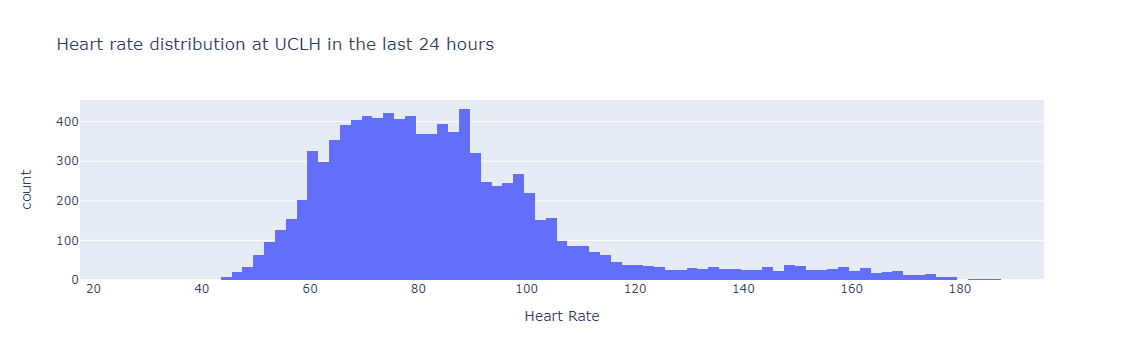

In [23]:
import plotly.express as px
figx = px.histogram(df, 
                    x='value_as_real',
                    title='Heart rate distribution at UCLH in the last 24 hours',
                   labels={'value_as_real': 'Heart Rate'})
figx.show()